In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os
import time
from timeit import default_timer as timer
import torch
from torch.autograd import Variable

import numpy as np
import pickle
import pathlib

if torch.cuda.is_available():
    print('cuda available')
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
else:
    print('cuda not available')
    dtypeFloat = torch.FloatTensor
    dtypeLong = torch.LongTensor

cuda not available


In [2]:
from core.DimReduction import DimReduction
from core.SimpleConvNet import SimpleConvNet
from core.GraphConvNet2 import GraphConvNet2
from core.DataEmbeddingGraph import DataEmbeddingGraph
from util.mnist_data_loader import get_train_set, get_test_set
from util.plot_embedding import plot_embedding, plot_embedding_subplot
from util.draw_random_subset import draw_random_subset

In [3]:
def save_checkpoint(state, filename):
    torch.save(state, filename)

In [4]:
dim_reduction = DimReduction(n_components=2)

In [5]:
task_parameters = {}
task_parameters['conv_type'] = 'conv_net'
task_parameters['reduction_method'] = 'spectral'
task_parameters['n_components'] = 2

net_parameters = {}
net_parameters['n_components'] = task_parameters['n_components']
net_parameters['D'] = 784 # input dimension
net_parameters['H'] = 50 # number of hidden units
net_parameters['L'] = 10 # number of hidden layers
net_parameters['n_channels'] = 1
net_parameters['n_units_1'] = net_parameters['n_units_2'] = net_parameters['H']

In [6]:
if task_parameters['conv_type'] == 'graph_net':
    net = GraphConvNet2(net_parameters)
elif task_parameters['conv_type'] == 'conv_net':
    net = SimpleConvNet(net_parameters)
if torch.cuda.is_available():
    net.cuda()
print(net)

SimpleConvNet(
  (conv1): Conv2d(1, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(50, 50, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (norm1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (norm2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=2450, out_features=2, bias=True)
)


In [7]:
# optimization parameters
opt_parameters = {}
opt_parameters['learning_rate'] = 0.00075   # ADAM
opt_parameters['max_iters'] = 100   
opt_parameters['max_train_size'] = 6000   
opt_parameters['batch_iters'] = 10
opt_parameters['save_flag'] = True

if 2==1: # fast debugging
    opt_parameters['max_iters'] = 25 
    opt_parameters['batch_iters'] = 5
    opt_parameters['save_flag'] = False

opt_parameters['decay_rate'] = 1.25   

In [8]:
# Load Mnist dataset
parent_dir = os.path.abspath('..')
data_dir = parent_dir + '/data/mnist'
train_data = get_train_set(data_dir)
test_data = get_test_set(data_dir)

In [9]:
if opt_parameters['save_flag']: 
    checkpoint_interval = opt_parameters['max_iters']/5
    checkpoint_root = 'results/mnist_spectral3/'
    pathlib.Path(checkpoint_root).mkdir(exist_ok=True) 

In [10]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: /Users/signapoop/Desktop/data/mnist
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.1307,), std=(0.3081,))
                         )
    Target Transforms (if any): None

In [11]:
# # Initialise train_loader based on batch size
# batch_size = 200

# train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
#                                            num_workers=2, pin_memory=False)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True,
#                                           num_workers=2, pin_memory=False)

In [12]:
all_train_data = []
num_train_samples = 0
while num_train_samples <= opt_parameters['max_train_size']:
    # Draw a random training batch of variable size
    num_samples = np.random.randint(200, 500)
    inputs, labels = draw_random_subset(train_data, num_samples=num_samples)
    
    # Package into graph block
    G = DataEmbeddingGraph(inputs, labels, task_parameters['reduction_method'])
    
    all_train_data.append(G)
    num_train_samples += num_samples

In [13]:
dataset_sizes = [len(G.labels) for G in all_train_data]
print("Dataset sizes = {}".format(dataset_sizes))
print("Total number of samples = {}".format(num_train_samples))

Dataset sizes = [335, 409, 219, 210, 255, 424, 245, 333, 206, 496, 310, 324, 310, 450, 209, 477, 413, 341, 463]
Total number of samples = 6429


In [14]:
# Optimization parameters
learning_rate = opt_parameters['learning_rate']
max_iters = opt_parameters['max_iters']
batch_iters = opt_parameters['batch_iters']
decay_rate = opt_parameters['decay_rate']

# Optimizer
global_lr = learning_rate
global_step = 0
lr = learning_rate
optimizer = net.update(lr) 

# Statistics
t_start = time.time()
t_start_total = time.time()
average_loss_old = 1e10
running_loss = 0.0
running_total = 0
    
for iteration in range(0, max_iters):
    
    for G in all_train_data:
        # Forward pass
        y_pred = net.forward(G)

        # Target embedding matrix
        y_true = G.target
        y_true = Variable(torch.FloatTensor(y_true).type(dtypeFloat) , requires_grad=False) 

        # Compute L2 loss
        loss = net.loss(y_pred, y_true)
        loss_train = loss.data[0]
        running_loss += loss_train
        running_total += 1

        # Backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # learning rate, print results
    if not iteration%batch_iters:

        # time
        t_stop = time.time() - t_start
        t_start = time.time()

        # update learning rate 
        average_loss = running_loss/ running_total
        if average_loss > 0.99* average_loss_old:
            lr /= decay_rate
        average_loss_old = average_loss
        optimizer = net.update_learning_rate(optimizer, lr)
        running_loss = 0.0
        running_total = 0

        # print results
        if 1==1:
            print('\niteration= %d, loss(%diter)= %.3f, lr= %.8f, time(%diter)= %.2f' % 
                  (iteration, batch_iters, average_loss, lr, batch_iters, t_stop))
    
    if opt_parameters['save_flag'] and not (iteration+1)%checkpoint_interval:
        filename = checkpoint_root + task_parameters['conv_type'] + str(int((iteration+1)/checkpoint_interval)) + '.pkl'
        save_checkpoint({
            'state_dict': net.state_dict(),
            'optimizer' : optimizer.state_dict(),
        }, filename)

/Users/signapoop/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number



iteration= 0, loss(10iter)= 0.511, lr= 0.00075000, time(10iter)= 22.33

iteration= 10, loss(10iter)= 0.105, lr= 0.00075000, time(10iter)= 218.61

iteration= 20, loss(10iter)= 0.095, lr= 0.00075000, time(10iter)= 216.28

iteration= 30, loss(10iter)= 0.091, lr= 0.00075000, time(10iter)= 211.78

iteration= 40, loss(10iter)= 0.086, lr= 0.00075000, time(10iter)= 217.98

iteration= 50, loss(10iter)= 0.081, lr= 0.00075000, time(10iter)= 228.53

iteration= 60, loss(10iter)= 0.073, lr= 0.00075000, time(10iter)= 223.86

iteration= 70, loss(10iter)= 0.063, lr= 0.00075000, time(10iter)= 224.97

iteration= 80, loss(10iter)= 0.060, lr= 0.00075000, time(10iter)= 223.11

iteration= 90, loss(10iter)= 0.052, lr= 0.00075000, time(10iter)= 224.42


## On test data

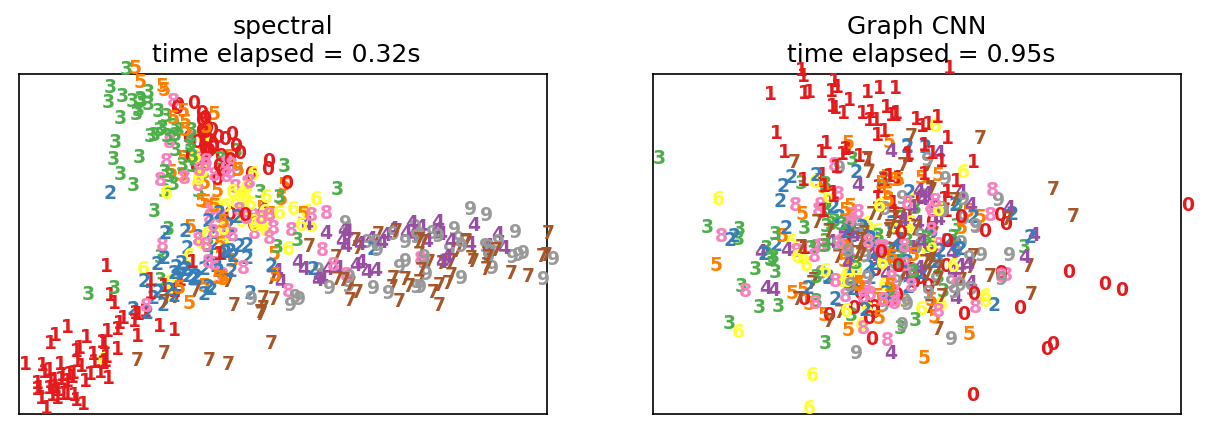

In [21]:
inputs, labels = draw_random_subset(test_data, num_samples=500)
G = DataEmbeddingGraph(inputs, labels, task_parameters['reduction_method'])
net_time_start = timer()
y_pred = net.forward(G).detach().numpy()
net_time_end = timer()

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(10, 3), dpi=150)
reduction_title = task_parameters['reduction_method'] + "\n time elapsed = {:.2f}s".format(G.time_to_compute) 
cnn_title = "Graph CNN" + "\n time elapsed = {:.2f}s".format(net_time_end - net_time_start) 
plot_embedding_subplot(axarr[0], G.target, G.labels.numpy(), reduction_title)
plot_embedding_subplot(axarr[1], y_pred, G.labels.numpy(), cnn_title)

In [16]:
import json
if opt_parameters['save_flag']:
    metadata_filename = checkpoint_root + "experiment_metadata.txt"
    json.dump([opt_parameters, net_parameters], open(metadata_filename,'w'))